In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import random

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier, MLPRegressor
from hmmlearn import hmm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Load Data

In [91]:
df_cus = pd.read_csv('../data/churn_dataset.csv')
df_cus = df_cus.loc[(df_cus.first_order_created_datetime >= "2017-01-01") & (df_cus.last_order_created_datetime < "2018-09-30")]

In [92]:
df_ord = pd.read_csv('../data/order_churn_data.csv')
df_ord = df_ord.merge(df_cus[['customer_db_id', 'completed_orders']], on='customer_db_id', how='left')

# Customer deltas

In [115]:
df_ord['order_created_datetime'] = pd.to_datetime(df_ord.order_created_datetime)
df_ord['order_created_day'] = df_ord.order_created_datetime.dt.weekday

In [116]:
df_deltas = df_ord[['customer_db_id', 'order_num', 'days_since_last_order', 
                    'days_until_next_order', 'order_state' , 'cluster_name',
                   'order_created_datetime', 'order_created_day', 'revenue']]

In [149]:
cust_sample = random.sample(df_deltas.loc[(df_deltas.order_num > 10) & (~df_deltas.cluster_name.isnull())]\
                            .customer_db_id.unique().tolist(), 10)
df_cust = df_deltas.loc[df_deltas.customer_db_id.isin(cust_sample)]

In [109]:
df_deltas.loc[df_deltas.customer_db_id == '5a1ee6e144770903118b466f'].corr()

,order_num,days_since_last_order,days_until_next_order,order_created_day,revenue
order_num,1.000000,-0.106002,-0.106002,0.112150,-0.240857
days_since_last_order,-0.106002,1.000000,-0.406515,-0.023737,0.228919
days_until_next_order,-0.106002,-0.406515,1.000000,0.065278,0.085618
order_created_day,0.112150,-0.023737,0.065278,1.000000,-0.103088
revenue,-0.240857,0.228919,0.085618,-0.103088,1.000000


In [4]:
cust_2orders = df_cus.loc[df_cus.completed_orders >= 3]['customer_db_id'].unique().tolist()

In [37]:
df_ord2 = df_ord.loc[(df_ord.customer_db_id.isin(cust_2orders)) & (df_ord.order_state == "completed")]
df_ord2 = df_ord2.sort_values(['customer_db_id', 'order_created_datetime'])

df_ord2['order_comp_num'] = df_ord2.groupby(['customer_db_id']).cumcount()
df_ord2['order_created_datetime'] = pd.to_datetime(df_ord2.order_created_datetime)

df_ord2['next_order_date'] = df_ord2.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_ord2['last_order_date'] = df_ord2.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_ord2['days_until_next_comp'] = (df_ord2.next_order_date - df_ord2.order_created_datetime).dt.days
df_ord2['days_since_last_comp'] = (df_ord2.order_created_datetime - df_ord2.last_order_date).dt.days

df_ord2['weeks_until_next_comp'] = df_ord2.days_until_next_comp // 7
df_ord2['weeks_since_last_comp'] = df_ord2.days_since_last_comp // 7

df_ord2['last_order_revenue'] = df_ord2.groupby('customer_db_id')['revenue'].shift(1)
df_ord2['last_revenue_diff'] = df_ord2.revenue - df_ord2.last_order_revenue

df_ord2['revenue_brutto'] = df_ord2.revenue + df_ord2.voucher_value

df_ord2 = df_ord2.drop(['next_order_date', 'last_order_date', 'last_order_revenue'], axis=1)

In [38]:
# df_ord2 = df_ord2.drop(['cluster', 'cluster_name'], axis=1)
# clusters = pd.read_csv('../data/clustering/item_clusters.csv')
# df_ord2 = df_ord2.merge(clusters, on='order_id')

In [39]:
# items = pd.read_csv('../data/input/items.csv')
# df_ord2 = df_ord2.merge(items, on='order_id')

In [40]:
df_ord2 = df_ord2.join(pd.get_dummies(df_ord2['cluster'], prefix='cluster'))
# df_ord2 = df_ord2.join(pd.get_dummies(df_ord2['product_group'], prefix='product'))
# df_ord2 = df_ord2.join(pd.get_dummies(df_ord2['service_class'], prefix='class'))
# df_ord2 = df_ord2.drop('product_Skiwear', axis=1)

In [41]:
df_ord2.head().T

,260274,139876,195366,230393,298268
order_id,GB-S-33739,GB-B-78803,GB-H-60995,GB-N-24594,GB-X-29500
customer_db_id,56e8cfd2d4cde8b932bae6a9,56e8cfd2d4cde8b932bae6a9,56e8cfd2d4cde8b932bae6a9,56e8cfd2d4cde8b932bae6a9,571b5744d2cde8e833ff595d
order_db_id,5904c69c4577094a458b45fb,5941223e457709913d8b45c3,59709c45457709413c8b456a,598fa413457709507a8b45c5,58ba8321447709d6158b4592
order_x,51.47,51.47,51.47,51.47,51.5542
order_y,-0.139703,-0.139703,-0.139703,-0.139703,-0.187987
pickup_timeslot_from_datetime,2017-04-30 12:00:00,2017-06-15 10:00:00,2017-07-21 10:30:00,2017-08-14 10:00:00,2017-03-05 08:00:00
pickup_timeslot_to_datetime,2017-04-30 12:30:00,2017-06-15 10:30:00,2017-07-21 11:00:00,2017-08-14 10:30:00,2017-03-05 10:00:00
pickup_zip,SW8 3JD,SW8 3JD,SW8 3JD,SW8 3JD,NW3 7EB
order_state,completed,completed,completed,completed,completed
order_created_datetime,2017-04-29 18:00:12,2017-06-14 12:47:10,2017-07-20 13:04:21,2017-08-13 01:57:55,2017-03-04 09:04:33


In [42]:
df_unknown = df_ord2.loc[(df_ord2.completed_orders == 3) & (df_ord2.order_comp_num == 2)]
df_known = df_ord2.loc[(df_ord2.completed_orders > 3) & (df_ord2.order_comp_num == 2)]

In [43]:
df_known = df_known.loc[df_known.city == 'London']
df_known = df_known.loc[(df_known.days_until_next_comp < 150) & (df_known.days_until_next_comp > 7)]
df_known = df_known.loc[(df_known.days_since_last_comp < 150) & (df_known.days_since_last_comp > 7)]
df_known = df_known.loc[df_known.revenue < 50]

In [44]:
df_known.revenue_brutto.describe()

count    1472.000000
mean       26.389631
std        10.630399
min         1.120203
25%        17.498345
50%        24.116227
75%        33.677070
max        79.239601
Name: revenue_brutto, dtype: float64

In [45]:
df_known.gender.value_counts()

male      1035
female     410
Name: gender, dtype: int64

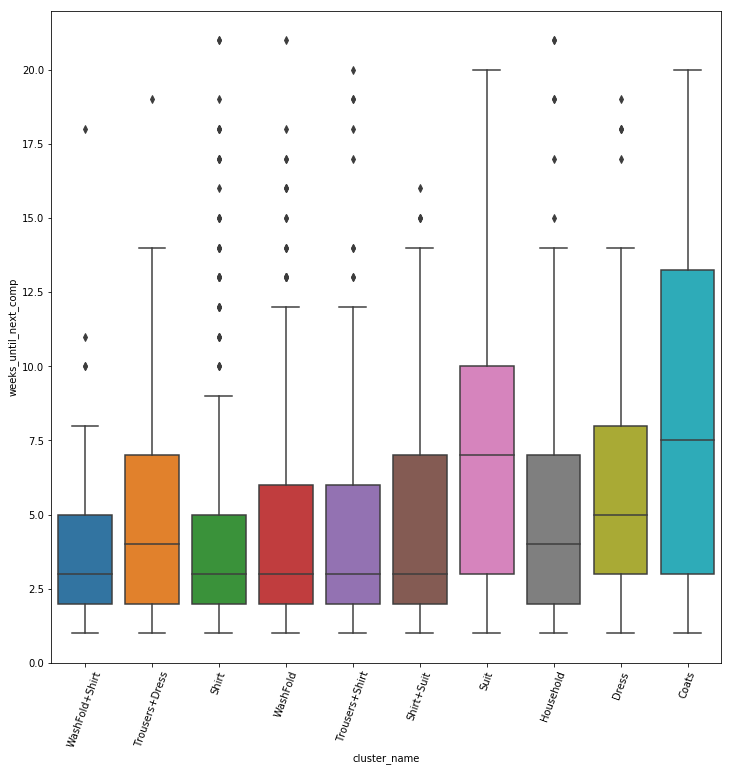

In [47]:
fig, ax = plt.subplots(figsize=(12,12))
plt.xticks(rotation=70)
sns.categorical.boxplot(data=df_known, x='cluster_name', y='weeks_until_next_comp')

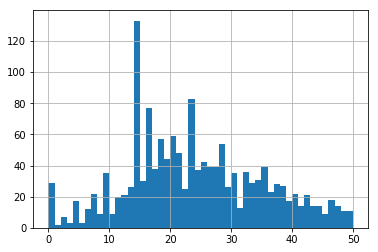

In [48]:
df_known.revenue.hist(bins=50)

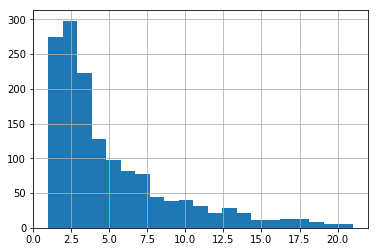

In [49]:
df_known.weeks_until_next_comp.hist(bins=df_known.weeks_until_next_comp.nunique())

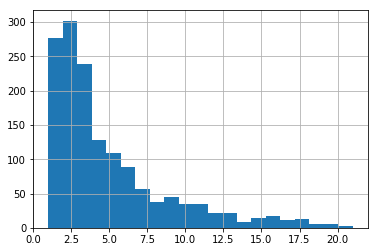

In [50]:
df_known.weeks_since_last_comp.hist(bins=df_known.weeks_since_last_comp.nunique())

In [51]:
df_known.shape

(1472, 88)

# Predictions

In [70]:
feats = ['gender', 'revenue_brutto', 'weeks_since_last_comp', 'days_since_last_comp'] + df_known.columns[-10:].tolist()
feats

['gender',
 'revenue_brutto',
 'weeks_since_last_comp',
 'days_since_last_comp',
 'cluster_0.0',
 'cluster_1.0',
 'cluster_2.0',
 'cluster_3.0',
 'cluster_4.0',
 'cluster_5.0',
 'cluster_6.0',
 'cluster_7.0',
 'cluster_8.0',
 'cluster_9.0']

In [71]:
# features
df_feats = df_known[['weeks_until_next_comp'] + feats]

df_feats['gender'] = df_feats.gender.map({'male': -1, 'female': 1}).fillna(0)

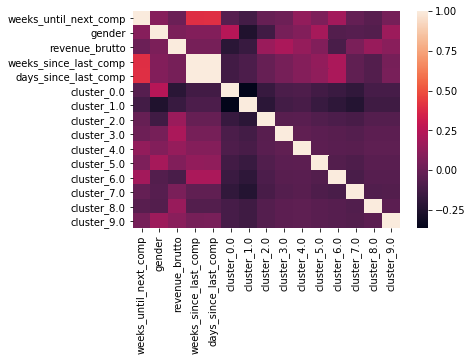

In [72]:
sns.heatmap(df_feats.corr())

In [73]:
X = df_feats.iloc[:, 1:].values
y = df_feats.iloc[:, 0].values
n_classes =  df_feats.iloc[:, 0].nunique()
n_classes

21

In [74]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
y_norm = y.reshape(-1,1)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.25, random_state=42)

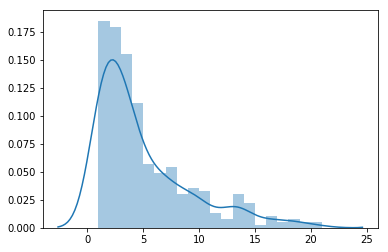

In [76]:
sns.distplot(y_test, bins=20)

In [77]:
reg = linear_model.LogisticRegression(class_weight='balanced').fit(X_train, y_train)
print('train', reg.score(X_train, y_train), 'test', reg.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_train, reg.predict(X_train).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))
acc = metrics.accuracy_score(y_test, reg.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

train 0.172101449275 test 0.116847826087
17.21%
11.685%


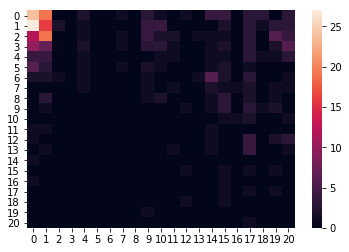

In [69]:
sns.heatmap(metrics.confusion_matrix(y_test, reg.predict(X_test).reshape(-1,1)))

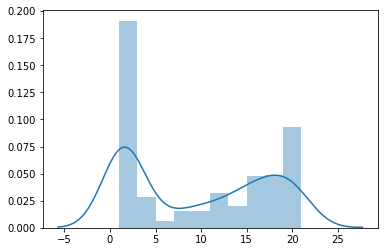

In [32]:
sns.distplot(reg.predict(X_test), bins=10)

In [33]:
reg = linear_model.().fit(X_train, y_train)
print('train', reg.score(X_train, y_train), 'test', reg.score(X_test, y_test)) 

SyntaxError: invalid syntax (<ipython-input-33-7734dfc8b74a>, line 1)

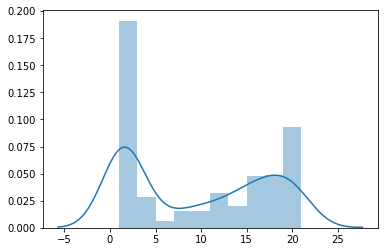

In [34]:
sns.distplot(reg.predict(X_test), bins=10)

In [35]:
sup = svm.SVC(class_weight='balanced', verbose=True, gamma='auto').fit(X_train, y_train)
print('train', sup.score(X_train, y_train), 'test', sup.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_test, sup.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

[LibSVM]train 0.184071729958 test 0.126382306477
12.638%


In [36]:
neigh = KNeighborsClassifier(n_neighbors=40).fit(X_train, y_train) 
neigh.score(X_test, y_test)
print('train', neigh.score(X_train, y_train), 'test', neigh.score(X_test, y_test))
acc = metrics.f1_score(y_test, neigh.predict(X_test), average='weighted')
print('{}%'.format(round(acc * 100, 3)))

train 0.245253164557 test 0.208530805687
15.261%


In [ ]:
frst = RandomForestClassifier(n_estimators=200, max_depth=4, class_weight='balanced').fit(X_train, y_train)
print('train', frst.score(X_train, y_train), 'test', frst.score(X_test, y_test))
acc = metrics.accuracy_score(y_test, frst.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10), random_state=1, max_iter=1000, 
                    learning_rate_init=0.001, verbose=True, batch_size=1, alpha=0.9).fit(X_train, y_train)
print('train', mlp.score(X_train, y_train), 'test', mlp.score(X_test, y_test))
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)
acc = metrics.accuracy_score(y_test, mlp.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

In [ ]:
sns.heatmap(metrics.confusion_matrix(y_test, mlp.predict(X_test).reshape(-1,1)))

In [ ]:
bys = linear_model.BayesianRidge().fit(X_train, y_train)
print('train', bys.score(X_train, y_train), 'test', bys.score(X_test, y_test))

In [ ]:
bys.predict(X_test)

In [ ]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full")